<a href="https://colab.research.google.com/github/CodingAIGibberish/Pr2NB_Model/blob/main/New_Bert_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import re

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import f1_score, confusion_matrix
from datasets import Dataset

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, precision_score, recall_score, accuracy_score, roc_curve, auc
from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:


# Define text cleaning function
def clean_text(text):
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Join tokens back into a string
    cleaned_text = ' '.join(tokens)

    return cleaned_text

# Load the train CSV file
train_file_path = '/content/train.csv'
df_train = pd.read_csv(train_file_path, encoding='ISO-8859-1')

# List of columns to drop
columns_to_drop = df_train.drop(columns=['keyword', 'location', 'id'])

# Check and clean the dataset
if 'target' in df_train.columns:
    df_train = df_train.rename(columns={'target': 'labels'})  # Rename target column to labels
df_train = df_train[['text', 'labels']]  # Retain only relevant columns
df_train.dropna(subset=['text', 'labels'], inplace=True)  # Remove rows with missing values
df_train['labels'] = df_train['labels'].astype(int)  # Ensure labels are integers
df_train['cleaned_text'] = df_train['text'].apply(clean_text)  # Clean text column

# Use a subset of the dataset for faster training
df_train = df_train.sample(frac=1, random_state=42)  # Use 100% of the data (EDITED FRAC FROM 0.5 TO 1: used 0.5 at first to decrease running time and to catch errors)

# Split data into training and testing sets
train_size = .8 # 0.8 of the dataset is being used for training and 0.20 for testing
train_df = df_train.sample(frac=train_size, random_state=42)
test_df = df_train.drop(train_df.index)

print(f"\nTraining samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df[['cleaned_text', 'labels']])
test_dataset = Dataset.from_pandas(test_df[['cleaned_text', 'labels']])

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')  # Use DistilBERT for faster training
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples['cleaned_text'], padding="max_length", truncation=True, max_length=64)  # Shorter max length

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["cleaned_text"])
tokenized_test = test_dataset.map(tokenize_function, batched=True, remove_columns=["cleaned_text"])

# Define metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "f1": f1_score(labels, predictions, average="weighted"),
        "confusion_matrix": confusion_matrix(labels, predictions).tolist(),
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results", #This is where the checkpoints and logs are saved
    evaluation_strategy="epoch", #Evaluation will happen at the end of each epoch
    learning_rate=2e-5, #The size of each update during training: High would learn faster but risk overshooting optimal solutions/ Smaller: more stable (better solution) but slower convergence (longer training)
    per_device_train_batch_size=32,  # Num of samples processed per training step. Higher bsize speeds training, improves stability, but req. more memory
    per_device_eval_batch_size=32, # Batch size during evaluation on each device. Larger eval: speed up evaluation, but req more mem / Smaller: req less mem, but training is noisier and slower
    num_train_epochs=2,  # Num of passes the model makes over the dataset. Increasing: improves performance but risks overfitting if set too high / Drecreasing: reduces training time, but won't learn enough from the data
    weight_decay=0.01, # Regulizes: penalizes large weights. Increasing: reduces overfitting, but may underfit / Decreasing: makes model flexible, but increases overfitting
    logging_dir="./logs", #This is the directory where the logs for training process are saved
    logging_steps= 9, # How often logs are written. Increasing: less freq. logging reduces interruptions, improves speed, but fewer insights / Decreasing: more logging, provides detailed insights, but slows down training
    fp16=True,  # Enable mixed precision for faster computation (uses less memory and accelerates computation by using half precision)/ False: would force a full 32-but precision
    save_total_limit=1,  # Save fewer checkpoints. Increasing: saves more checkpoints, keeps more training snapshots, takes up more diskspace/ Decreasing: reduces disk space but reduces ability to go back to earlier checkpoints
    report_to="none",
)

df_train.head()


Training samples: 6090
Testing samples: 1523


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


,text,labels,cleaned_text
2644,So you have a new weapon that can cause un-ima...,1,new weapon cause unimaginable destruction
2227,The f$&amp;@ing things I do for #GISHWHES Just...,0,famping things gishwhes got soaked deluge goin...
5448,DT @georgegalloway: RT @Galloway4Mayor: ÂÃÃ...,1,dt georgegalloway rt gallowaymayor col police ...
132,Aftershock back to school kick off was great. ...,0,aftershock back school kick great want thank e...
6845,in response to trauma Children of Addicts deve...,0,response trauma children addicts develop defen...


In [4]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-4-9df94e104c18>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [5]:
# Train the model
print("\nStarting training...")
trainer.train()
print("\nTraining complete.")


Starting training...


Epoch,Training Loss,Validation Loss,F1,Confusion Matrix
1,0.451900,0.433211,0.820295,"[[752, 142], [132, 497]]"
2,0.313100,0.427119,0.828241,"[[786, 108], [152, 477]]"



Training complete.


In [6]:
# Evaluate the model
print("\nEvaluating the model...")
eval_results = trainer.evaluate()
print("\nEvaluation Results:")
print(eval_results)


Evaluating the model...



Evaluation Results:
{'eval_loss': 0.42711928486824036, 'eval_f1': 0.8282406919714421, 'eval_confusion_matrix': [[786, 108], [152, 477]], 'eval_runtime': 162.7738, 'eval_samples_per_second': 9.357, 'eval_steps_per_second': 0.295, 'epoch': 2.0}



Generating predictions on the test dataset...



Confusion Matrix:
[[786 108]
 [152 477]]


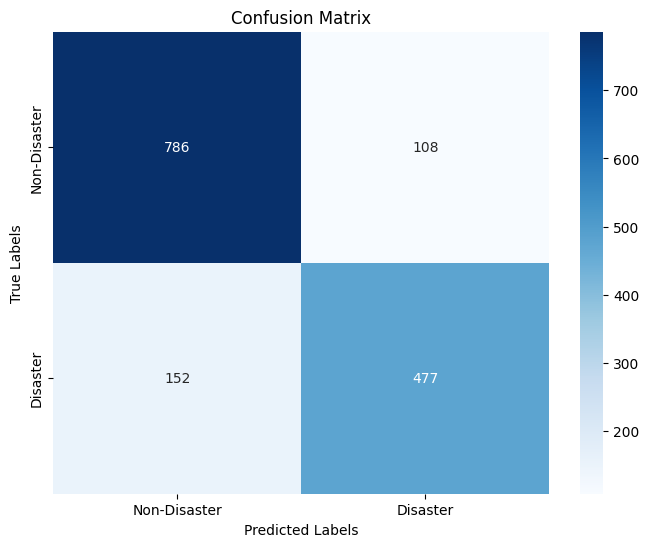

In [7]:
# Generate predictions on the test dataset
print("\nGenerating predictions on the test dataset...")
predictions = trainer.predict(tokenized_test)

# Extract logits and labels
logits = predictions.predictions # Raw model outputs before softmax
labels = predictions.label_ids # True labels for each test sample

# Compute binary predictions for the confusion matrix
predicted_labels = np.argmax(logits, axis=-1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, predicted_labels)

# Print the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Disaster', 'Disaster'], yticklabels=['Non-Disaster', 'Disaster'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

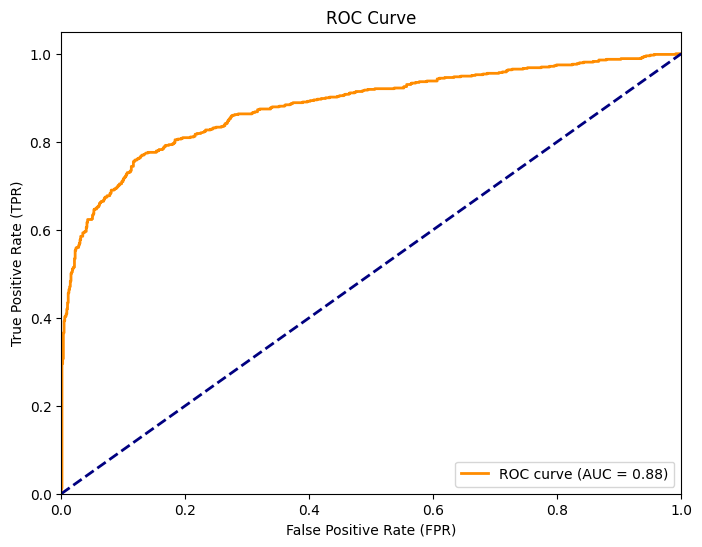

In [8]:
# Compute softmax to get probability scores
probs = torch.softmax(torch.tensor(logits), dim=1).numpy()  # Probability scores for each class
prob_positive_class = probs[:, 1]  # Probability of the positive class (class 1)

# Generate ROC curve using probability scores for positive class
fpr, tpr, _ = roc_curve(labels, prob_positive_class)
roc_auc = auc(fpr, tpr)

# ROC Curve Graph
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [9]:
print(roc_auc)

0.8807293278276302


In [10]:
# Generate Clasificacion Report
report = classification_report(labels, predicted_labels, target_names=["Fake Tweet", "Real Tweet"])

# Print Report
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

  Fake Tweet       0.84      0.88      0.86       894
  Real Tweet       0.82      0.76      0.79       629

    accuracy                           0.83      1523
   macro avg       0.83      0.82      0.82      1523
weighted avg       0.83      0.83      0.83      1523



In [11]:
# Save the fine-tuned model and tokenizer
# Definir el directorio donde guardar el modelo y el tokenizador
results = '/content/results'

model.save_pretrained('results')
tokenizer.save_pretrained('results')

print("\nFine-tuned model and tokenizer saved successfully.")

# Save Trained model
torch.save(model.state_dict(), 'new_bert_model.pth')


Fine-tuned model and tokenizer saved successfully.
